# Search for cleanup and help before submission
- [ ] refine pipeline, maybe watch lect for it thur w4
- [ ] guess/check or grid search to tune hyperparameters
- [ ] confusion matrix axes label order?
- [ ] conclusion

# CITS5508 Lab 2: Classification on Forest Type

Name: Joey Koh<br>
Student number: 21506379  
Date created: 10 March 2020  
Last modified: 16 March 2020  

This notebook goes through the steps of a typical machine learning project. It is addressing a multi-class classification task on predicting forest type using spectral characteristic attributes.<br>

A Support Vector Classifier and Stochastic Gradient Descent Classifier are evaluated in performance and compared.

## 1. Setup, Data Loading and Visualisation
Import libraries to be used and bring the data in.<br>
Perform basic visualisations to have a feel of data. <br>

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
#Use jupyter's backend to render plots
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics

#Prepare the data
def load_data(training_csv,test_csv):
    training_data = pd.read_csv(training_csv)
    test_data =pd.read_csv(test_csv)
    return training_data,test_data

#Declare file names
training_file = "training.csv"
test_file = "test.csv"
training_data,test_data = load_data(training_file,test_file)

#Inspect columns with first few lines
training_data.head()

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,67,51,68,115,69,111,136,31,67,...,-9.17,-18.27,-1.80,-6.32,-20.88,-1.63,-6.13,-22.56,-5.53,-8.11
1,s,67,28,51,99,50,97,82,26,59,...,-2.25,-20.13,-2.11,-6.35,-21.94,-1.22,-6.13,-22.20,-3.41,-6.57
2,s,63,26,50,95,49,91,81,26,57,...,-0.44,-17.64,-1.81,-4.70,-19.39,-0.65,-5.01,-20.89,-3.96,-6.85
3,d,63,42,63,97,66,108,111,28,59,...,-2.34,-20.20,-1.89,-5.47,-21.65,-0.99,-5.71,-22.19,-3.41,-6.52
4,s,46,27,50,83,51,90,76,26,56,...,1.25,-18.62,-2.17,-7.11,-21.12,-1.56,-6.35,-22.19,-4.45,-7.32


These are the **first few lines** of the **training data**

In [2]:
test_data.head()

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,39,36,57,91,59,101,93,27,60,...,-2.36,-18.41,-1.88,-6.43,-21.03,-1.60,-6.18,-22.50,-5.20,-7.86
1,h,84,30,57,112,51,98,92,26,62,...,-2.26,-16.27,-1.95,-6.25,-18.79,-1.99,-6.18,-23.41,-8.87,-10.83
2,s,53,25,49,99,51,93,84,26,58,...,-1.46,-15.92,-1.79,-4.64,-17.73,-0.48,-4.69,-19.97,-4.10,-7.07
3,s,59,26,49,103,47,92,82,25,56,...,2.68,-13.77,-2.53,-6.34,-22.03,-2.34,-6.60,-27.10,-7.99,-10.81
4,d,57,49,66,103,64,106,114,28,59,...,-2.94,-21.74,-1.64,-4.62,-23.74,-0.85,-5.50,-22.83,-2.74,-5.84


These are the **first few lines** of the **testing data**

### 1.1 Visualisations

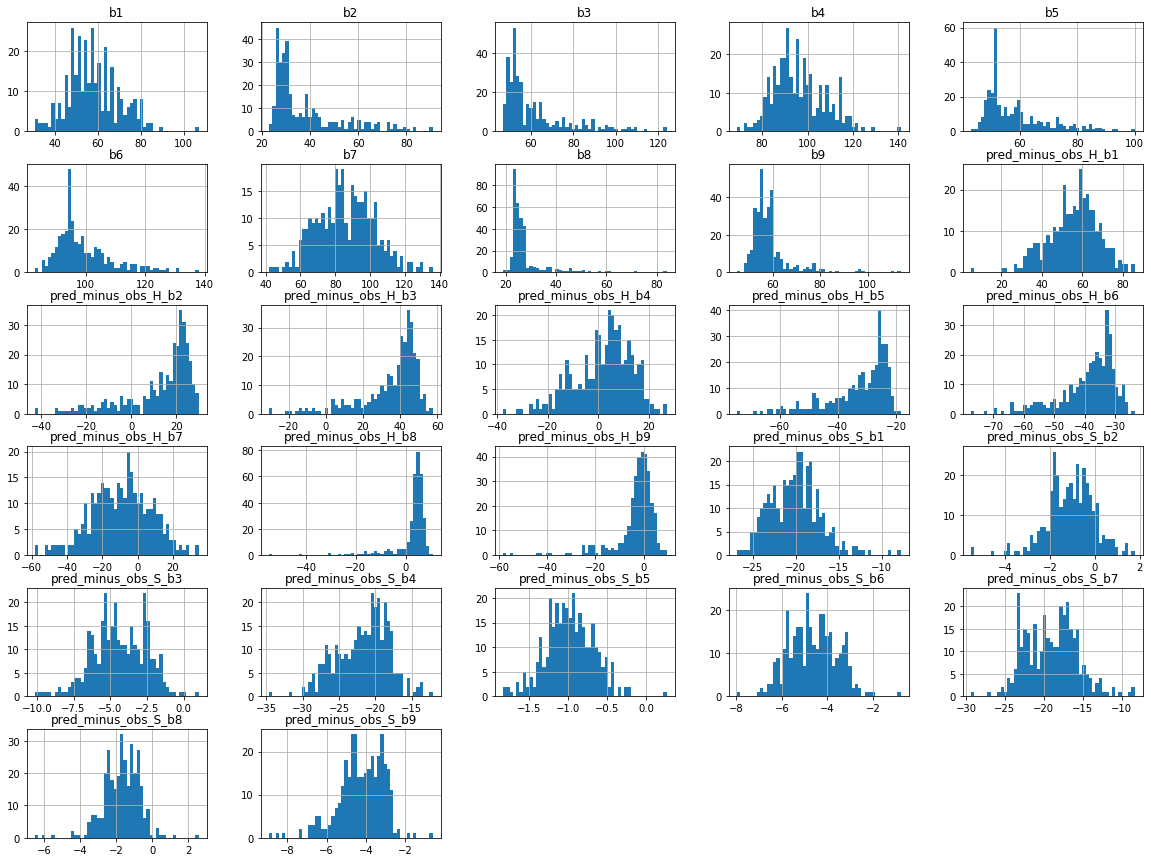

In [3]:
#Generate histograms
training_data.hist(bins=50, figsize=(20,15))
plt.show()

From these histograms of the training data, it can be observed that:<br>
* Most attributes are normally distributed
* The attributes have different scales, hence we would likely need feature scaling
* Most b1-b9 attributes are tail-heavy. They extend much further to the right of the median than left.
* Most pred_minus_obs_H b1 to b9 attributes are head-heavy. They extend much further to the left of median than right.
* Most pred_minus_obs_S b1 to b9 attributes are normally distributed around the middle of its range
* Approximating the median for each attribute to be around the middle of the normal distribution hump, the far tails/heads values could potentially be outliers. It might be better to use StandardScaler rather than MinMaxScaler in data normalisation due to outliers.

[Text(0, 0.5, 'pred minus obs S'), Text(0.5, 0, 'b (spectral wavelength)')]

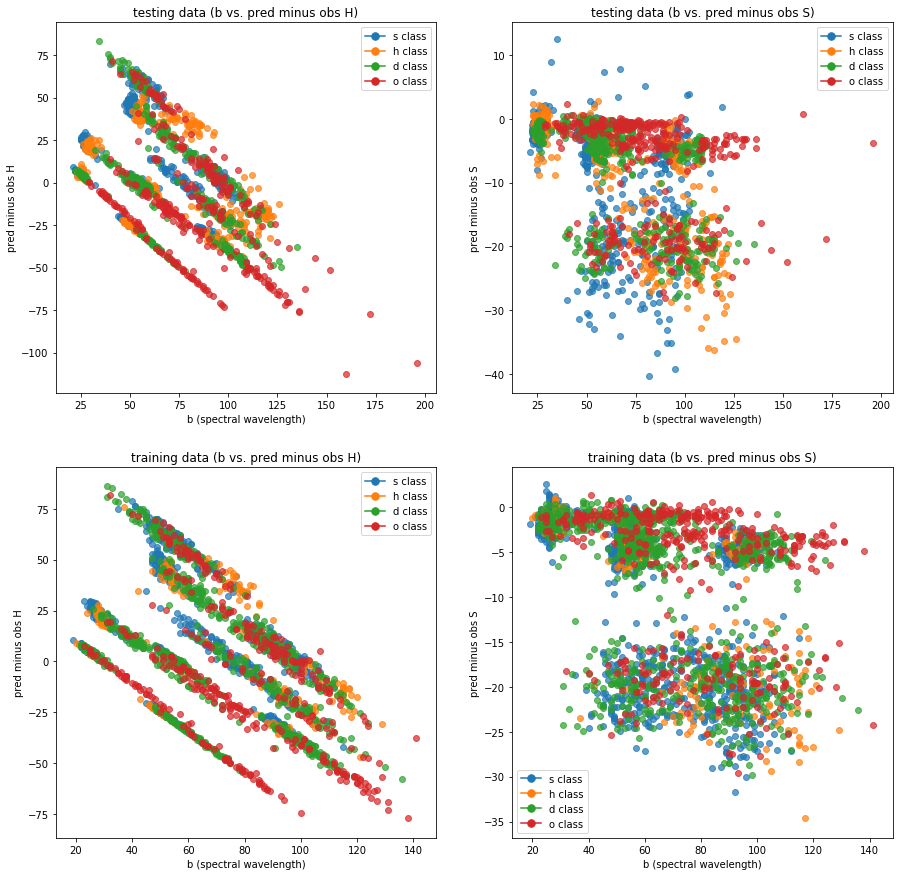

In [4]:
#For graph legends
s_plot = mlines.Line2D([], [], color="#1f77b4", marker=".", markersize=15, label="s class")
h_plot = mlines.Line2D([], [], color="#ff7f0e", marker=".", markersize=15, label="h class")
d_plot = mlines.Line2D([], [], color="#2ca02c", marker=".", markersize=15, label="d class")
o_plot = mlines.Line2D([], [], color="#d62728", marker=".", markersize=15, label="o class")

#Extract and separate train data by classes
train_s = training_data[training_data["class"] == "s "]
train_h = training_data[training_data["class"] == "h "]
train_d = training_data[training_data["class"] == "d "]
train_o = training_data[training_data["class"] == "o "]

#Extract and separate train data by classes
test_s = test_data[test_data["class"] == "s "]
test_h = test_data[test_data["class"] == "h "]
test_d = test_data[test_data["class"] == "d "]
test_o = test_data[test_data["class"] == "o "]

#Prepare plots
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# Graph scatterplots of each graph with information provided by the titles and labels
# Data from testing dataset, b vs pred minus obs H
ax1.scatter(test_s[test_s.columns[1:10]], test_s[test_s.columns[10:19]], color="#1f77b4", alpha=0.7)
ax1.scatter(test_h[test_h.columns[1:10]], test_h[test_h.columns[10:19]], color="#ff7f0e", alpha=0.7)
ax1.scatter(test_d[test_d.columns[1:10]], test_d[test_d.columns[10:19]], color="#2ca02c", alpha=0.7)
ax1.scatter(test_o[test_o.columns[1:10]], test_o[test_o.columns[10:19]], color="#d62728", alpha=0.7)
ax1.legend(handles=[s_plot, h_plot, d_plot, o_plot])
ax1.set_title('testing data (b vs. pred minus obs H)')
ax1.set(xlabel="b (spectral wavelength)",ylabel="pred minus obs H")

# Data from testing dataset, b vs pred minus obs S
ax2.scatter(test_s[test_s.columns[1:10]], test_s[test_s.columns[19:28]], color="#1f77b4", alpha=0.7)
ax2.scatter(test_h[test_h.columns[1:10]], test_h[test_h.columns[19:28]], color="#ff7f0e", alpha=0.7)
ax2.scatter(test_d[test_d.columns[1:10]], test_d[test_d.columns[19:28]], color="#2ca02c", alpha=0.7)
ax2.scatter(test_o[test_o.columns[1:10]], test_o[test_o.columns[19:28]], color="#d62728", alpha=0.7)
ax2.legend(handles=[s_plot, h_plot, d_plot, o_plot])
ax2.set_title('testing data (b vs. pred minus obs S)')
ax2.set(xlabel="b (spectral wavelength)",ylabel="pred minus obs S")

# Data from training dataset, b vs pred minus obs H
ax3.scatter(train_s[train_s.columns[1:10]], train_s[train_s.columns[10:19]], color="#1f77b4", alpha=0.7)
ax3.scatter(train_h[train_h.columns[1:10]], train_h[train_h.columns[10:19]], color="#ff7f0e", alpha=0.7)
ax3.scatter(train_d[train_d.columns[1:10]], train_d[train_d.columns[10:19]], color="#2ca02c", alpha=0.7)
ax3.scatter(train_o[train_o.columns[1:10]], train_o[train_o.columns[10:19]], color="#d62728", alpha=0.7)
ax3.legend(handles=[s_plot, h_plot, d_plot, o_plot])
ax3.set_title('training data (b vs. pred minus obs H)')
ax3.set(xlabel="b (spectral wavelength)",ylabel="pred minus obs H")

# Data from training dataset, b vs pred minus obs S
ax4.scatter(train_s[train_s.columns[1:10]], train_s[train_s.columns[19:28]], color="#1f77b4", alpha=0.7)
ax4.scatter(train_h[train_h.columns[1:10]], train_h[train_h.columns[19:28]], color="#ff7f0e", alpha=0.7)
ax4.scatter(train_d[train_d.columns[1:10]], train_d[train_d.columns[19:28]], color="#2ca02c", alpha=0.7)
ax4.scatter(train_o[train_o.columns[1:10]], train_o[train_o.columns[19:28]], color="#d62728", alpha=0.7)
ax4.legend(handles=[s_plot, h_plot, d_plot, o_plot])
ax4.set_title('training data (b vs. pred minus obs S)')
ax4.set(xlabel="b (spectral wavelength)",ylabel="pred minus obs S")

### Analysis

When the features are graphed against the predicted minus obs H, various parallel lines are distinctly present. This is evident in both the testing and training datasets. The four classes are all distributed across the lines. This shows there is a correlation in the data which is promising for a machine learning task. 

For the graphs on the right, where it is against predicted minus obs S, there seems to be a different relationship, although there are no lines formed, there is two clusters of data points which seem to have evenly distributed classes amongst themselves.

Both these graphs shows strong evidence of a relationship existing in the data and across all classes. Furthermore the training and testing data shows the same relationship between each other which is good for training and validation later on.

In [5]:
#cleanup graph cell and analysis, joeyify it

## 2. Data Cleaning, Checking and Normalisation
Remove unneeded columns, extract labels, check for training set balance, perform feature scaling, and create pipeline.

In [15]:
def drop_columns(df): #function to remove all columns starting with "pred_minus_obs"
    df = df[df.columns.drop(list(df.filter(regex="pred_minus_obs")))]
    return df

def separate_pipeline(df):
    df = drop_columns(df) #Remove all columns starting with "pred_minus_obs"
    df_y = df["class"]  #Extract class labels
    print("For this dataset, these are the number of instances for each class label")
    print(df_y.value_counts(),"\n")   #Count instances for class labels in training set
    df_x = df.drop("class", axis=1) #separate predictors from labels
    df_x.describe()  #get an idea of the data distribution
    return df_y, df_x

def scaler_pipeline(df,df_train_x): #for data normalisation
    std_scaler = StandardScaler()
    std_scaler.fit(df_train_x)
    return std_scaler.transform(df)
    
def main_pipeline(train_dataset, test_dataset):
    print("For the training dataset:\n")
    train_y, train_x = separate_pipeline(train_dataset)
    print("For the testing dataset:\n")
    test_y, test_x = separate_pipeline(test_dataset)
    train_x_tr = scaler_pipeline(train_x, train_x)
    test_x_tr = scaler_pipeline(test_x, train_x)
    return train_y, train_x, test_y, test_x, train_x_tr, test_x_tr

train_y, train_x, test_y, test_x, train_x_tr, test_x_tr = main_pipeline(training_data, test_data)

For the training dataset:

For this dataset, these are the number of instances for each class label
s     136
d     105
o      46
h      38
Name: class, dtype: int64 

For the testing dataset:

For this dataset, these are the number of instances for each class label
s     59
d     54
h     48
o     37
Name: class, dtype: int64 



### 2.1 Remove unwanted columns

In [ ]:
#Remove all columns starting with "pred_minus_obs"
def drop_columns(df):
    df = df[df.columns.drop(list(df.filter(regex="pred_minus_obs")))]
    return df

training_data = drop_columns(training_data)
test_data = drop_columns(test_data)

### 2.2 Extract labels

In [ ]:
#Extract class labels from both datasets
train_y = training_data["class"]
test_y = test_data["class"]

### 2.3 Check balance of training set

In [ ]:
#Count instances for class labels in training set
print("For training data, these are the number of instances for each class label")
train_y.value_counts()

From this, **we clearly have an imbalanced training dataset.** With 's' and 'd' classes having the most instances relative to 'o' and 'h' classes.<br>
(Class: 's' ('Sugi' forest), 'h' ('Hinoki' forest), 'd' ('Mixed deciduous' forest), 'o' ('Other' non-forest land)

### 2.4 Data Normalisation with a Pipeline
cleanup: using minmaxscaler, standardscaler or any suitable normailisation func in the sklearn.preprocessing package<br>
help: which one to use?
write a python function that defines the pipeline for all cleaning operations above

In [ ]:
#separate predictors from labels
train_x = training_data.drop("class", axis=1)
test_x = test_data.drop("class", axis=1)

In [ ]:
#get an idea of the data distribution CLEANUP: is this needed? dont the histograms show the outliers
train_x.describe()

Looking at the distribution of the values at min, 25%, 50%, 75% and max – in combination to the observations from the histograms in Section 1.1, there are likely outliers which a StandardScaler would deal better with compared to a MinMaxScaler.

In [ ]:
#Prepare pipeline

num_pipeline = Pipeline([
    ("std_scaler", StandardScaler())
])

train_x_tr = num_pipeline.fit_transform(train_x) #bad because it cannot fit transform y (cannot fit on y)


In [ ]:
def num2_pipeline(df): #help why is Standard Scalar not defined?
    a_pipeline = Pipeline([
        ('std_scaler', StandardScalar())
    ])
    ft_df = a_pipeline.fit_transform(df)
    return ft_df
    
t3 = num2_pipeline(train_x)

In [ ]:
def lpipe(df):
    lnum_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])
    trr = lnum_pipeline.fit_transform(df)
    return trr

dasdas = lpipe(train_x)

In [ ]:
def num3_pipeline(df):
    std_scaler = StandardScaler()
    std_scaler.fit(train_x)
    return std_scaler.transform(df)

train_x_tr = num3_pipeline(train_x)
test_x_tr = num3_pipeline(test_x)

## 3. Support Vector Classifier
one vs one binary classication on the 4 class labels

In [ ]:
#fit SVC model with training data
svm_clf = SVC()
svm_clf.fit(train_x_tr,train_y);

In [ ]:
#help: try experimenting with 2 or 3 hyperparameters to improve performance

In [ ]:
#generate test data label prediction
test_y_svm_pred = svm_clf.predict(test_x_tr)

### 3.1 Tune Hyperparameters with Grid Search

In [ ]:

param_grid = [
    {'kernels' : ['linear', 'rbf', 'poly'],
    'gammas' : [0.1, 1, 10, 100],
    'C' : [0.1, 1, 10, 100, 1000]
    }
]

svm_clf = SVC()

grid_search_svm = GridSearchCV(svm_clf, 
                               param_grid, 
                               scoring = 'f1',
                               return_train_score = True)

#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

#grid_search_sgd.fit(train_x_tr, train_y)


In [ ]:
param_grid = [
    {'kernels' : ['linear', 'rbf', 'poly'],
    'gammas' : [0.1, 1, 10, 100],
    'C' : [0.1, 1, 10, 100, 1000]
    }
]

svm_clf = SVC()

grid_search_svm = GridSearchCV(svm_clf, 
                               param_grid, 
                               scoring = 'f1')

#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

grid_search_svm.fit(train_x_tr, train_y)


### 3.2 Confusion Matrix 

In [ ]:

#confusion matrix generation
conf_mx_svm = confusion_matrix(test_y, test_y_svm_pred)
print("This is the confusion matrix\n",conf_mx_svm)

#visualisation setup
alpha = ['d', 'h', 'o', 's']
data = conf_mx_svm

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show
print("Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis")

In [ ]:
print(metrics.accuracy_score(test_y, test_y_svm_pred))

## 4. Stochastic Gradient Descent Classifier

In [ ]:
#fit SGD model with training data
sgd_clf = SGDClassifier()
sgd_clf.fit(train_x_tr, train_y);

In [ ]:
#generate test data label prediction
test_y_sgd_pred = sgd_clf.predict(test_x_tr)

### 4.1 Tune Hyperparameters with Grid Search

In [ ]:

param_grid = [
    {'alpha': [0.0001],#[0.0001, 0.001, 0.01, 0.1]
    'penalty': ['l1','l2','elasticnet'], #['l1','l2','elasticnet']
    'n_jobs': [-1]
    }
]

grid_search_sgd = GridSearchCV(estimator =sgd_clf, 
                               param_grid = param_grid, 
                               cv=5,
                               scoring = 'f1',
                              return_train_score = True)
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

#a = grid_search_sgd.fit(train_x_tr, train_y)

"""
grid = {
    'C': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'penalty': ['l2'],
    'n_jobs': [-1]
}
"""


In [ ]:
grid_search_sgd


### 4.2 Confusion Matrix 

In [ ]:

#confusion matrix generation
conf_mx_sgd = confusion_matrix(test_y, test_y_sgd_pred)
print("This is the confusion matrix\n",conf_mx_sgd)

#visualisation setup
alpha = ['d', 'h', 'o', 's']
data = conf_mx_sgd

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show
print("Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis")

## 5. Conclusion